In [ ]:

#import necessary packages 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, Optional,List, Dict
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import RectBivariateSpline
import xesmf as xe
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings


In [32]:
#load in the data using xarray 
merra2_data=xr.open_dataset("merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc", engine="netcdf4")
nldas_data= xr.open_dataset("nldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
fldas_data= xr.open_dataset("fldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
gldas_data= xr.open_dataset("gldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
era5_data=xr.open_dataset('/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',engine='cfgrib')

#create dataset dictionary 

datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

# Define variable names for each dataset
var_names = {
    'MERRA2': 'SFMC',  # Surface soil moisture content
    'NLDAS': 'SoilM_0_10cm',
    'FLDAS': 'SoilMoi00_10cm_tavg',
    'GLDAS': 'SoilMoi0_10cm_inst',
    'ERA5': 'swvl1'  # Volumetric soil water layer 1
}

In [55]:
import xarray as xr
import numpy as np

def standardize_coords(ds, var_name):
    """
    Standardize coordinate names to lat/lon and select the variable
    """
    # Create a mapping of common coordinate names
    coord_names = {
        'latitude': ['latitude', 'lat', 'Y'],
        'longitude': ['longitude', 'lon', 'X']
    }
    
    # Find the actual coordinate names in the dataset
    lat_name = None
    lon_name = None
    
    for coord in ds.coords:
        if coord.lower() in [x.lower() for x in coord_names['latitude']]:
            lat_name = coord
        elif coord.lower() in [x.lower() for x in coord_names['longitude']]:
            lon_name = coord
    
    # Rename coordinates if they exist
    if lat_name and lon_name:
        ds = ds.rename({lat_name: 'latitude', lon_name: 'longitude'})
    
    # Select only the variable we want
    if var_name in ds:
        ds = ds[[var_name]]
    
    return ds

# Process each dataset
processed_datasets = {}

for name, ds in datasets.items():
    try:
        # Get the variable name for this dataset
        var_name = var_names[name]
        
        # Standardize coordinates and select variable
        processed_ds = standardize_coords(ds, var_name)
        
        # Store in processed datasets dictionary
        processed_datasets[name] = processed_ds
        
        print(f"Successfully processed {name} dataset")
        
    except Exception as e:
        print(f"Error processing {name} dataset: {str(e)}")

# Save processed datasets
for name, ds in processed_datasets.items():
    try:
        output_filename = f"{name.lower()}_processed.nc"
        ds.to_netcdf(output_filename)
        print(f"Saved {name} dataset to {output_filename}")
    except Exception as e:
        print(f"Error saving {name} dataset: {str(e)}")

# Print information about processed datasets
for name, ds in processed_datasets.items():
    print(f"\nDataset: {name}")
    print("Coordinates:")
    print(ds.coords)
    print("Variables:")
    print(ds.variables)

Successfully processed MERRA2 dataset
Successfully processed NLDAS dataset
Successfully processed FLDAS dataset
Successfully processed GLDAS dataset
Successfully processed ERA5 dataset
Saved MERRA2 dataset to merra2_processed.nc
Saved NLDAS dataset to nldas_processed.nc
Saved FLDAS dataset to fldas_processed.nc
Saved GLDAS dataset to gldas_processed.nc
Error saving ERA5 dataset: [Errno 13] Permission denied: '/Users/alicemonroe/Documents/GitHub/Stats/era5_processed.nc'

Dataset: MERRA2
Coordinates:
Coordinates:
  * longitude  (longitude) float64 104B -79.38 -78.75 -78.12 ... -72.5 -71.88
  * latitude   (latitude) float64 80B 40.5 41.0 41.5 42.0 ... 44.0 44.5 45.0
  * time       (time) datetime64[ns] 1kB 2013-01-01T00:30:00 ... 2023-12-01T0...
Variables:
Frozen({'SFMC': <xarray.Variable (time: 132, latitude: 10, longitude: 13)> Size: 69kB
array([[[0.366179, 0.327121, ..., 0.298288, 0.250823],
        [0.372117, 0.310434, ..., 0.260264, 0.234082],
        ...,
        [0.253332, 0.247737

In [56]:
import xarray as xr
import numpy as np
import pandas as pd

def print_dataset_statistics(name, ds):
    """
    Print comprehensive statistics for a dataset
    """
    print(f"\n{'='*50}")
    print(f"Statistics for {name} Dataset")
    print('='*50)
    
    # Get the variable name
    var_name = list(ds.data_vars)[0]
    
    # Basic dataset information
    print("\nDataset Information:")
    print(f"Variable name: {var_name}")
    print(f"Time period: {ds.time.values[0]} to {ds.time.values[-1]}")
    print(f"Number of timesteps: {len(ds.time)}")
    print(f"Spatial coverage:")
    print(f"  Latitude:  {ds.latitude.values.min():.2f}° to {ds.latitude.values.max():.2f}°")
    print(f"  Longitude: {ds.longitude.values.min():.2f}° to {ds.longitude.values.max():.2f}°")
    print(f"  Spatial resolution: {abs(ds.latitude[1] - ds.latitude[0]):.2f}°")
    
    # Calculate basic statistics
    print("\nBasic Statistics:")
    data = ds[var_name]
    stats = {
        'Mean': float(data.mean()),
        'Median': float(data.median()),
        'Std Dev': float(data.std()),
        'Min': float(data.min()),
        'Max': float(data.max())
    }
    
    for stat_name, value in stats.items():
        print(f"{stat_name}: {value:.4f}")
    
    # Calculate monthly climatology
    print("\nMonthly Climatology:")
    monthly_means = data.groupby('time.month').mean()
    monthly_stds = data.groupby('time.month').std()
    
    for month in range(1, 13):
        print(f"Month {month:2d}: Mean = {float(monthly_means[month-1]):.4f}, "
              f"Std = {float(monthly_stds[month-1]):.4f}")
    
    # Calculate percentage of missing values
    total_points = np.prod(data.shape)
    missing_points = np.isnan(data).sum()
    missing_percentage = (missing_points/total_points) * 100
    
    print(f"\nMissing Values: {missing_percentage:.2f}%")

# Try to read in all processed datasets
try:
    processed_datasets = {}
    dataset_names = ['MERRA2', 'NLDAS', 'FLDAS', 'GLDAS', 'ERA5']
    
    for name in dataset_names:
        filename = f"{name.lower()}_processed.nc"
        try:
            ds = xr.open_dataset(filename)
            processed_datasets[name] = ds
            print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
    
    # Print statistics for each dataset
    for name, ds in processed_datasets.items():
        try:
            print_dataset_statistics(name, ds)
        except Exception as e:
            print(f"Error processing statistics for {name}: {str(e)}")
            
    # Optional: Create a comparative summary table
    print("\nComparative Summary:")
    print('='*50)
    
    summary_data = []
    for name, ds in processed_datasets.items():
        var_name = list(ds.data_vars)[0]
        data = ds[var_name]
        
        summary_data.append({
            'Dataset': name,
            'Mean': float(data.mean()),
            'Std Dev': float(data.std()),
            'Min': float(data.min()),
            'Max': float(data.max()),
            'Missing (%)': (np.isnan(data).sum() / np.prod(data.shape) * 100)
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.round(4))

except Exception as e:
    print(f"An error occurred: {str(e)}")

finally:
    # Close all datasets
    for ds in processed_datasets.values():
        ds.close()

Successfully loaded merra2_processed.nc
Successfully loaded nldas_processed.nc
Successfully loaded fldas_processed.nc
Successfully loaded gldas_processed.nc
Successfully loaded era5_processed.nc

Statistics for MERRA2 Dataset

Dataset Information:
Variable name: SFMC
Time period: 2013-01-01T00:30:00.000000000 to 2023-12-01T00:30:00.000000000
Number of timesteps: 132
Spatial coverage:
  Latitude:  40.50° to 45.00°
  Longitude: -79.38° to -71.88°
  Spatial resolution: 0.50°

Basic Statistics:
Mean: 0.2624
Median: 0.2646
Std Dev: 0.0585
Min: 0.0841
Max: 0.4069

Monthly Climatology:
Error processing statistics for MERRA2: only length-1 arrays can be converted to Python scalars

Statistics for NLDAS Dataset

Dataset Information:
Variable name: SoilM_0_10cm
Time period: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
Number of timesteps: 132
Spatial coverage:
  Latitude:  40.56° to 44.94°
  Longitude: -79.69° to -71.94°
  Spatial resolution: 0.12°

Basic Statistics:
Mean: 29.3

In [57]:
#regrid the data to the era5 and save as new datasets 
#make sure to deal with the lat/lon names for the different datasets 

import xarray as xr
import numpy as np
from xesmf import Regridder

def create_regridder(ds_in, ds_out, method='bilinear'):
    """
    Create a regridder object for interpolation
    """
    return Regridder(ds_in, ds_out, method, periodic=False, reuse_weights=False)

def prepare_dataset_for_regridding(ds):
    """
    Prepare dataset for regridding by ensuring it has proper coordinates
    """
    # Make sure longitude is between -180 and 180
    if ds.longitude.max() > 180:
        ds['longitude'] = xr.where(ds['longitude'] > 180, 
                                 ds['longitude'] - 360, 
                                 ds['longitude'])
        ds = ds.sortby('longitude')
    
    return ds

def regrid_dataset(ds, target_grid, var_name):
    """
    Regrid a dataset to match the target grid
    """
    # Prepare dataset
    ds = prepare_dataset_for_regridding(ds)
    
    # Create regridder
    regridder = create_regridder(ds, target_grid)
    
    # Regrid the data
    regridded_data = regridder(ds[var_name])
    
    # Create new dataset with regridded data
    ds_out = xr.Dataset({var_name: (['time', 'latitude', 'longitude'], regridded_data.values)},
                        coords={'time': ds.time,
                               'latitude': target_grid.latitude,
                               'longitude': target_grid.longitude})
    
    return ds_out

try:
    # Load all processed datasets
    processed_datasets = {}
    dataset_names = ['MERRA2', 'NLDAS', 'FLDAS', 'GLDAS', 'ERA5']
    
    for name in dataset_names:
        filename = f"{name.lower()}_processed.nc"
        try:
            ds = xr.open_dataset(filename)
            processed_datasets[name] = ds
            print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")

    # Get ERA5 grid as target
    target_grid = processed_datasets['ERA5']
    
    # Dictionary to store regridded datasets
    regridded_datasets = {}
    regridded_datasets['ERA5'] = processed_datasets['ERA5']  # ERA5 doesn't need regridding
    
    # Regrid each dataset
    for name, ds in processed_datasets.items():
        if name != 'ERA5':  # Skip ERA5 as it's our target grid
            try:
                print(f"\nRegridding {name} dataset...")
                
                # Get variable name
                var_name = list(ds.data_vars)[0]
                
                # Perform regridding
                regridded_ds = regrid_dataset(ds, target_grid, var_name)
                
                # Store regridded dataset
                regridded_datasets[name] = regridded_ds
                
                print(f"Successfully regridded {name} dataset")
                
                # Save regridded dataset
                output_filename = f"{name.lower()}_regridded.nc"
                regridded_ds.to_netcdf(output_filename)
                print(f"Saved regridded dataset to {output_filename}")
                
                # Print basic comparison
                original_shape = ds[var_name].shape
                regridded_shape = regridded_ds[var_name].shape
                print(f"Original shape: {original_shape}")
                print(f"Regridded shape: {regridded_shape}")
                
            except Exception as e:
                print(f"Error regridding {name} dataset: {str(e)}")

    # Print summary of regridding results
    print("\nRegridding Summary:")
    print("="*50)
    for name, ds in regridded_datasets.items():
        var_name = list(ds.data_vars)[0]
        print(f"\n{name}:")
        print(f"Shape: {ds[var_name].shape}")
        print(f"Latitude range: {ds.latitude.values.min():.2f}° to {ds.latitude.values.max():.2f}°")
        print(f"Longitude range: {ds.longitude.values.min():.2f}° to {ds.longitude.values.max():.2f}°")
        print(f"Resolution: {abs(ds.latitude[1] - ds.latitude[0]):.3f}°")

except Exception as e:
    print(f"An error occurred: {str(e)}")

finally:
    # Close all datasets
    for ds in processed_datasets.values():
        ds.close()
    for ds in regridded_datasets.values():
        ds.close()

Successfully loaded merra2_processed.nc
Successfully loaded nldas_processed.nc
Successfully loaded fldas_processed.nc
Successfully loaded gldas_processed.nc
Successfully loaded era5_processed.nc

Regridding MERRA2 dataset...
Successfully regridded MERRA2 dataset
Error regridding MERRA2 dataset: [Errno 13] Permission denied: '/Users/alicemonroe/Documents/GitHub/Stats/merra2_regridded.nc'

Regridding NLDAS dataset...
Successfully regridded NLDAS dataset
Error regridding NLDAS dataset: [Errno 13] Permission denied: '/Users/alicemonroe/Documents/GitHub/Stats/nldas_regridded.nc'

Regridding FLDAS dataset...
Successfully regridded FLDAS dataset
Error regridding FLDAS dataset: [Errno 13] Permission denied: '/Users/alicemonroe/Documents/GitHub/Stats/fldas_regridded.nc'

Regridding GLDAS dataset...
Successfully regridded GLDAS dataset
Error regridding GLDAS dataset: [Errno 13] Permission denied: '/Users/alicemonroe/Documents/GitHub/Stats/gldas_regridded.nc'

Regridding Summary:

ERA5:
Shape: (1

In [58]:
# normalize and center data 
# calculate correlation matrix and shared variance 

import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def load_and_prepare_data(dataset_names):
    """
    Load regridded datasets and prepare them for correlation analysis
    """
    datasets = {}
    data_arrays = {}
    
    for name in dataset_names:
        try:
            # Load dataset
            filename = f"{name.lower()}_regridded.nc"
            if name == 'ERA5':
                filename = f"{name.lower()}_processed.nc"  # ERA5 wasn't regridded
                
            ds = xr.open_dataset(filename)
            datasets[name] = ds
            
            # Get the variable name and data
            var_name = list(ds.data_vars)[0]
            data = ds[var_name].values
            
            # Print initial data info
            print(f"\n{name} dataset:")
            print(f"Shape: {data.shape}")
            print(f"NaN count: {np.isnan(data).sum()}")
            print(f"Value range: {np.nanmin(data):.3f} to {np.nanmax(data):.3f}")
            
            # Reshape to 2D array (time, space)
            shape = data.shape
            data_2d = data.reshape(shape[0], -1)
            
            # Handle NaN values by filling with column means
            col_means = np.nanmean(data_2d, axis=0)
            col_means[np.isnan(col_means)] = 0  # Replace any NaN means with 0
            mask = np.isnan(data_2d)
            data_2d[mask] = np.take(col_means, np.where(mask)[1])
            
            # Normalize data
            scaler = StandardScaler()
            data_normalized = scaler.fit_transform(data_2d)
            
            # Store normalized data
            data_arrays[name] = data_normalized
            
            print(f"After processing:")
            print(f"NaN count: {np.isnan(data_normalized).sum()}")
            print(f"Value range: {np.min(data_normalized):.3f} to {np.max(data_normalized):.3f}")
            
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
    
    return datasets, data_arrays

def calculate_correlation_matrix(data_arrays):
    """
    Calculate correlation matrix between datasets
    """
    names = list(data_arrays.keys())
    n = len(names)
    corr_matrix = np.zeros((n, n))
    
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            # Get the data arrays
            data1 = data_arrays[name1]
            data2 = data_arrays[name2]
            
            # Calculate correlation
            valid_mask = ~np.isnan(data1.flatten()) & ~np.isnan(data2.flatten())
            if valid_mask.any():
                corr = np.corrcoef(data1.flatten()[valid_mask], 
                                 data2.flatten()[valid_mask])[0, 1]
            else:
                corr = np.nan
            
            corr_matrix[i, j] = corr
            
            # Print debugging info
            if i != j:
                print(f"\nCorrelation between {name1} and {name2}:")
                print(f"Correlation value: {corr}")
    
    return pd.DataFrame(corr_matrix, index=names, columns=names)

def calculate_shared_variance_matrix(corr_matrix):
    """
    Calculate shared variance matrix (R-squared)
    """
    return corr_matrix ** 2

def plot_matrices(corr_matrix, var_matrix):
    """
    Create and save correlation and shared variance matrix plots
    """
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot correlation matrix
    sns.heatmap(corr_matrix, 
                annot=True, 
                fmt='.3f',
                cmap='RdBu_r', 
                vmin=-1, 
                vmax=1, 
                center=0,
                ax=ax1)
    ax1.set_title('Correlation Matrix')
    
    # Plot shared variance matrix
    sns.heatmap(var_matrix, 
                annot=True, 
                fmt='.3f',
                cmap='YlOrRd', 
                vmin=0, 
                vmax=1,
                ax=ax2)
    ax2.set_title('Shared Variance Matrix')
    
    plt.tight_layout()
    plt.savefig('correlation_variance_matrices.png', dpi=300, bbox_inches='tight')
    plt.close()

def print_summary_statistics(corr_matrix, var_matrix):
    """
    Print summary statistics for correlations and shared variances
    """
    print("\nCorrelation Summary:")
    print("="*50)
    
    # Get unique pairs (excluding self-correlations)
    names = corr_matrix.index
    pairs = []
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            pairs.append((names[i], names[j]))
    
    # Print correlation and shared variance for each pair
    for pair in pairs:
        corr = corr_matrix.loc[pair[0], pair[1]]
        var = var_matrix.loc[pair[0], pair[1]]
        print(f"\n{pair[0]} vs {pair[1]}:")
        print(f"Correlation: {corr:.3f}")
        print(f"Shared Variance: {var:.3f}")

try:
    # Define dataset names
    dataset_names = ['MERRA2', 'NLDAS', 'FLDAS', 'GLDAS', 'ERA5']
    
    # Load and prepare data
    print("Loading and preparing datasets...")
    datasets, data_arrays = load_and_prepare_data(dataset_names)
    
    # Calculate correlation matrix
    print("\nCalculating correlation matrix...")
    corr_matrix = calculate_correlation_matrix(data_arrays)
    
    # Calculate shared variance matrix
    print("\nCalculating shared variance matrix...")
    var_matrix = calculate_shared_variance_matrix(corr_matrix)
    
    # Create plots
    print("\nCreating plots...")
    plot_matrices(corr_matrix, var_matrix)
    
    # Print summary statistics
    print_summary_statistics(corr_matrix, var_matrix)
    
    print("\nAnalysis complete! Plots have been saved as 'correlation_variance_matrices.png'")

except Exception as e:
    print(f"An error occurred: {str(e)}")

finally:
    # Close all datasets
    for ds in datasets.values():
        ds.close()

Loading and preparing datasets...

MERRA2 dataset:
Shape: (132, 46, 80)
NaN count: 0
Value range: 0.000 to 0.406
After processing:
NaN count: 0
Value range: -3.025 to 2.853

NLDAS dataset:
Shape: (132, 46, 80)
NaN count: 67188
Value range: 0.000 to 47.600
After processing:
NaN count: 0
Value range: -3.045 to 6.277

FLDAS dataset:
Shape: (132, 46, 80)
NaN count: 63624
Value range: 0.000 to 0.468
After processing:
NaN count: 0
Value range: -6.555 to 6.762

GLDAS dataset:
Shape: (132, 46, 80)
NaN count: 70356
Value range: 0.000 to 47.575
After processing:
NaN count: 0
Value range: -2.750 to 7.717

ERA5 dataset:
Shape: (132, 46, 80)
NaN count: 16104
Value range: 0.010 to 0.494
After processing:
NaN count: 0
Value range: -11.446 to 5.291

Calculating correlation matrix...

Correlation between MERRA2 and NLDAS:
Correlation value: 0.4478592236764302

Correlation between MERRA2 and FLDAS:
Correlation value: 0.5912693096785656

Correlation between MERRA2 and GLDAS:
Correlation value: 0.56906901

/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_86610/1724763498.py:43: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(data_2d, axis=0)
/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_86610/1724763498.py:43: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(data_2d, axis=0)
/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_86610/1724763498.py:43: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(data_2d, axis=0)
/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_86610/1724763498.py:43: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(data_2d, axis=0)



Correlation Summary:

MERRA2 vs NLDAS:
Correlation: 0.448
Shared Variance: 0.201

MERRA2 vs FLDAS:
Correlation: 0.591
Shared Variance: 0.350

MERRA2 vs GLDAS:
Correlation: 0.569
Shared Variance: 0.324

MERRA2 vs ERA5:
Correlation: 0.664
Shared Variance: 0.441

NLDAS vs FLDAS:
Correlation: 0.649
Shared Variance: 0.421

NLDAS vs GLDAS:
Correlation: 0.829
Shared Variance: 0.688

NLDAS vs ERA5:
Correlation: 0.442
Shared Variance: 0.195

FLDAS vs GLDAS:
Correlation: 0.703
Shared Variance: 0.494

FLDAS vs ERA5:
Correlation: 0.559
Shared Variance: 0.312

GLDAS vs ERA5:
Correlation: 0.540
Shared Variance: 0.291

Analysis complete! Plots have been saved as 'correlation_variance_matrices.png'



Processing: MERRA2_vs_NLDAS

Processing: MERRA2_vs_FLDAS

Processing: MERRA2_vs_GLDAS

Processing: MERRA2_vs_ERA5

Processing: NLDAS_vs_FLDAS

Processing: NLDAS_vs_GLDAS

Processing: NLDAS_vs_ERA5

Processing: FLDAS_vs_GLDAS

Processing: FLDAS_vs_ERA5

Processing: GLDAS_vs_ERA5


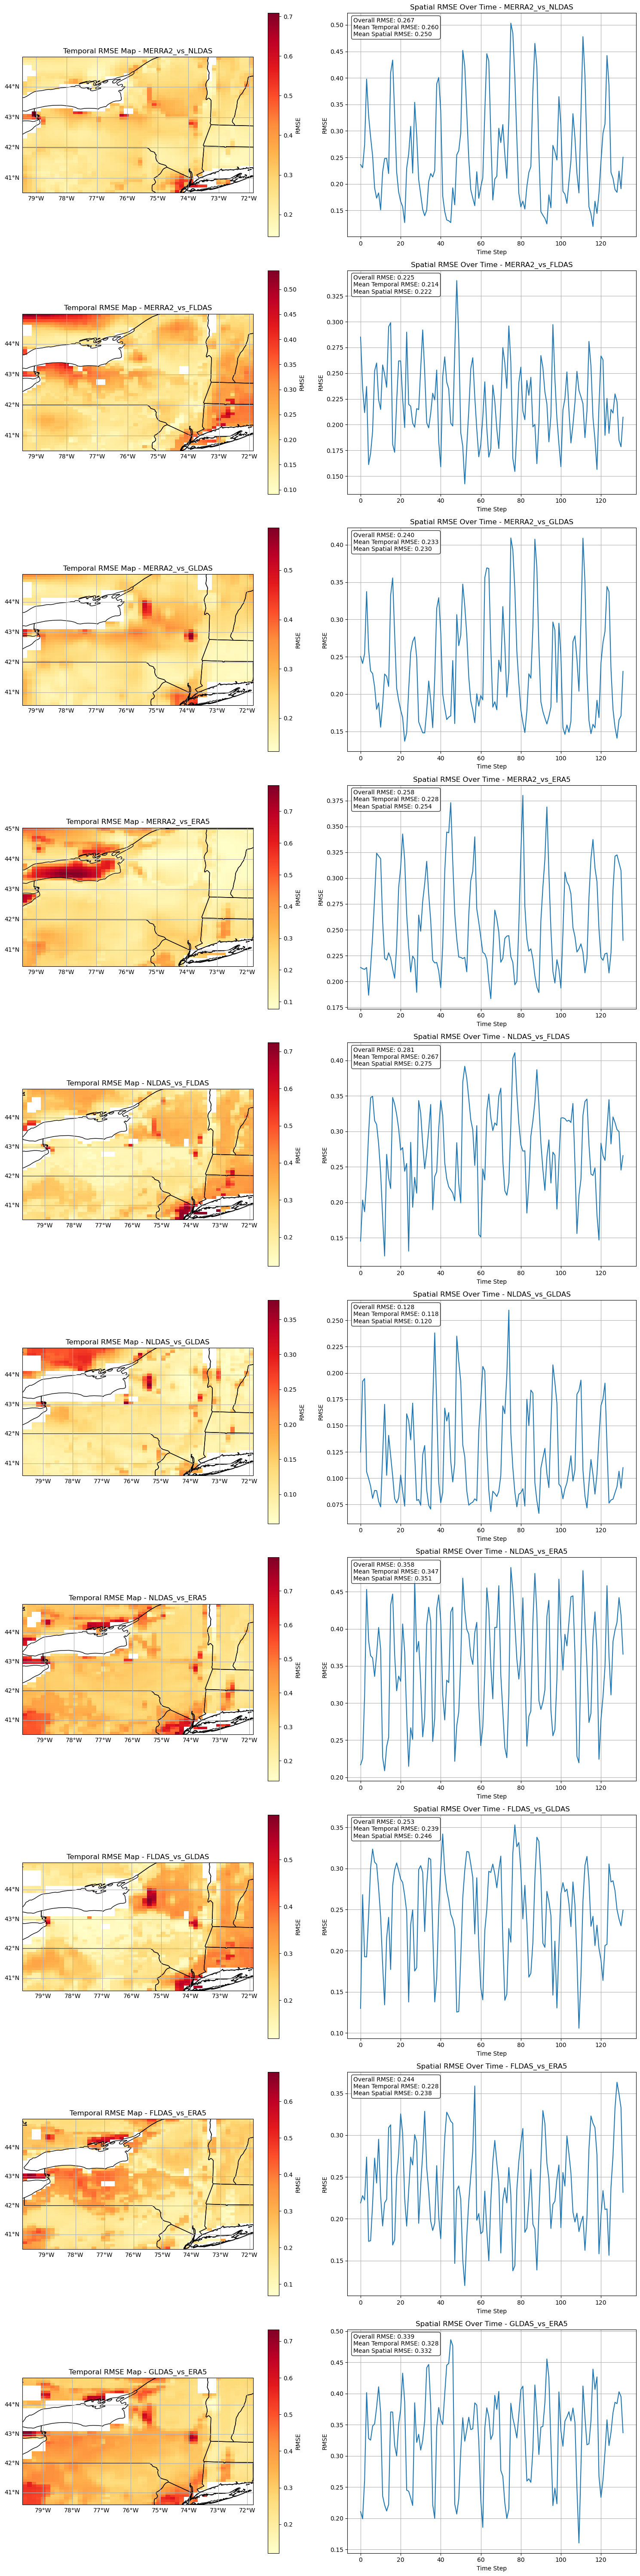

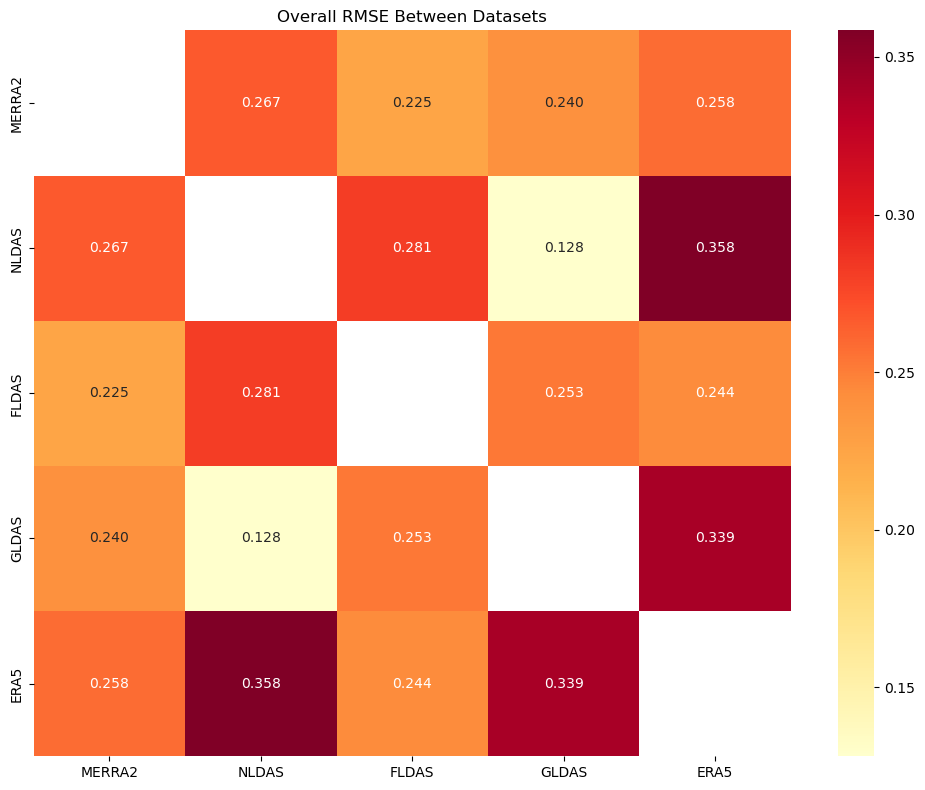

In [59]:
#calculate rmse and plot 
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple, Union

# Load datasets
datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

# Variable names
var_names = {
    'MERRA2': 'SFMC',
    'NLDAS': 'SoilM_0_10cm',
    'FLDAS': 'SoilMoi00_10cm_tavg',
    'GLDAS': 'SoilMoi0_10cm_inst',
    'ERA5': 'swvl1'
}

# Create processed datasets dictionary
processed_datasets = {}
for name, ds in datasets.items():
    var_name = var_names[name]
    if var_name in ds:
        processed_datasets[name] = ds[[var_name]]

# Function definitions
def normalize_soil_moisture(ds, var_name):
    var = ds[var_name]
    valid_data = var.values[~np.isnan(var.values)]
    vmin = np.percentile(valid_data, 1)
    vmax = np.percentile(valid_data, 99)
    normalized = (var - vmin) / (vmax - vmin)
    normalized = normalized.clip(0, 1)
    return ds.assign({var_name: normalized})

def get_coordinate_names(ds):
    lat_names = ['latitude', 'lat', 'Y']
    lon_names = ['longitude', 'lon', 'X']
    all_names = list(ds.coords) + list(ds.dims)
    lat_name = next((name for name in lat_names if name in all_names), None)
    lon_name = next((name for name in lon_names if name in all_names), None)
    if lat_name is None or lon_name is None:
        raise ValueError(f"Could not find coordinates in: {all_names}")
    return lat_name, lon_name

def calculate_rmse(original, regridded, debug=True):
    if isinstance(original, xr.DataArray):
        original = original.to_dataset()
    if isinstance(regridded, xr.DataArray):
        regridded = regridded.to_dataset()
    
    orig_lat_name, orig_lon_name = get_coordinate_names(original)
    regrid_lat_name, regrid_lon_name = get_coordinate_names(regridded)
    
    # Time coordinate handling
    time_names = ['time', 'valid_time']
    orig_time_name = next((name for name in time_names if name in original.dims), None)
    regrid_time_name = next((name for name in time_names if name in regridded.dims), None)
    
    if orig_time_name and regrid_time_name:
        original = original.assign_coords({
            orig_time_name: pd.to_datetime(original[orig_time_name].values)
        })
        regridded = regridded.assign_coords({
            regrid_time_name: pd.to_datetime(regridded[regrid_time_name].values)
        })
        
        orig_times = original[orig_time_name].values
        regrid_times = regridded[regrid_time_name].values
        
        if len(orig_times) <= len(regrid_times):
            reference_times = orig_times
            regridded = regridded.sel({regrid_time_name: reference_times}, method='nearest')
            common_times = reference_times
        else:
            reference_times = regrid_times
            original = original.sel({orig_time_name: reference_times}, method='nearest')
            common_times = reference_times
    
    # Create common grid
    new_lat = np.linspace(
        max(original[orig_lat_name].min(), regridded[regrid_lat_name].min()),
        min(original[orig_lat_name].max(), regridded[regrid_lat_name].max()),
        50
    )
    new_lon = np.linspace(
        max(original[orig_lon_name].min(), regridded[regrid_lon_name].min()),
        min(original[orig_lon_name].max(), regridded[regrid_lon_name].max()),
        50
    )
    
    # Interpolate
    original_interp = original.interp({orig_lat_name: new_lat, orig_lon_name: new_lon})
    regridded_interp = regridded.interp({regrid_lat_name: new_lat, regrid_lon_name: new_lon})
    
    # Get variables
    orig_var = list(original.data_vars)[0]
    regrid_var = list(regridded.data_vars)[0]
    
    # Normalize
    original_interp = normalize_soil_moisture(original_interp, orig_var)
    regridded_interp = normalize_soil_moisture(regridded_interp, regrid_var)
    
    # Calculate metrics
    diff = original_interp[orig_var].values - regridded_interp[regrid_var].values
    mask = ~np.isnan(diff)
    overall_rmse = np.sqrt(np.mean(diff[mask]**2))
    
    temporal_rmse = np.zeros((len(new_lat), len(new_lon)))
    spatial_rmse = np.zeros(len(common_times))
    
    for i in range(len(new_lat)):
        for j in range(len(new_lon)):
            mask = ~np.isnan(original_interp[orig_var].values[:, i, j]) & ~np.isnan(regridded_interp[regrid_var].values[:, i, j])
            if np.any(mask):
                temporal_rmse[i, j] = np.sqrt(np.mean((
                    original_interp[orig_var].values[:, i, j][mask] - 
                    regridded_interp[regrid_var].values[:, i, j][mask]
                )**2))
            else:
                temporal_rmse[i, j] = np.nan
    
    for t in range(len(common_times)):
        mask = ~np.isnan(original_interp[orig_var].values[t]) & ~np.isnan(regridded_interp[regrid_var].values[t])
        if np.any(mask):
            spatial_rmse[t] = np.sqrt(np.mean((
                original_interp[orig_var].values[t][mask] - 
                regridded_interp[regrid_var].values[t][mask]
            )**2))
        else:
            spatial_rmse[t] = np.nan
    
    return {
        'overall_rmse': overall_rmse,
        'temporal_rmse': temporal_rmse,
        'spatial_rmse': spatial_rmse,
        'temporal_mean_rmse': np.nanmean(temporal_rmse),
        'spatial_mean_rmse': np.nanmean(spatial_rmse),
        'lat': new_lat,
        'lon': new_lon,
        'variables_compared': (orig_var, regrid_var),
        'n_timesteps': len(common_times)
    }

# Calculate RMSE for all pairs
rmse_results = {}
dataset_names = list(processed_datasets.keys())
for i in range(len(dataset_names)):
    for j in range(i + 1, len(dataset_names)):
        name1, name2 = dataset_names[i], dataset_names[j]
        pair_name = f"{name1}_vs_{name2}"
        print(f"\nProcessing: {pair_name}")
        rmse_stats = calculate_rmse(processed_datasets[name1], processed_datasets[name2])
        rmse_results[pair_name] = rmse_stats

# Plot results
fig = plt.figure(figsize=(15, 6 * len(rmse_results)))
plot_idx = 0

for pair_name, results in rmse_results.items():
    # Map subplot
    ax1 = fig.add_subplot(len(rmse_results), 2, plot_idx * 2 + 1, projection=ccrs.PlateCarree())
    lons, lats = np.meshgrid(results['lon'], results['lat'])
    
    temporal_rmse = np.ma.masked_invalid(results['temporal_rmse'])
    im1 = ax1.pcolormesh(
        lons, lats, temporal_rmse,
        transform=ccrs.PlateCarree(),
        cmap='YlOrRd',
        shading='auto'
    )
    
    ax1.coastlines()
    ax1.add_feature(cfeature.STATES.with_scale('50m'))
    gl = ax1.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    plt.colorbar(im1, ax=ax1, label='RMSE')
    ax1.set_title(f'Temporal RMSE Map - {pair_name}')
    
    # Time series subplot
    ax2 = fig.add_subplot(len(rmse_results), 2, plot_idx * 2 + 2)
    ax2.plot(results['spatial_rmse'])
    ax2.set_title(f'Spatial RMSE Over Time - {pair_name}')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RMSE')
    ax2.grid(True)
    
    # Add statistics
    stats_text = (
        f"Overall RMSE: {results['overall_rmse']:.3f}\n"
        f"Mean Temporal RMSE: {results['temporal_mean_rmse']:.3f}\n"
        f"Mean Spatial RMSE: {results['spatial_mean_rmse']:.3f}"
    )
    ax2.text(0.02, 0.98, stats_text,
             transform=ax2.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plot_idx += 1

plt.tight_layout()
plt.show()

# Create summary matrix
n_datasets = len(dataset_names)
rmse_matrix = np.full((n_datasets, n_datasets), np.nan)

for pair_name, results in rmse_results.items():
    ds1, ds2 = pair_name.split('_vs_')
    i = dataset_names.index(ds1)
    j = dataset_names.index(ds2)
    rmse_matrix[i, j] = results['overall_rmse']
    rmse_matrix[j, i] = results['overall_rmse']

plt.figure(figsize=(10, 8))
sns.heatmap(rmse_matrix,
            mask=np.isnan(rmse_matrix),
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            xticklabels=dataset_names,
            yticklabels=dataset_names)
plt.title('Overall RMSE Between Datasets')
plt.tight_layout()
plt.show()

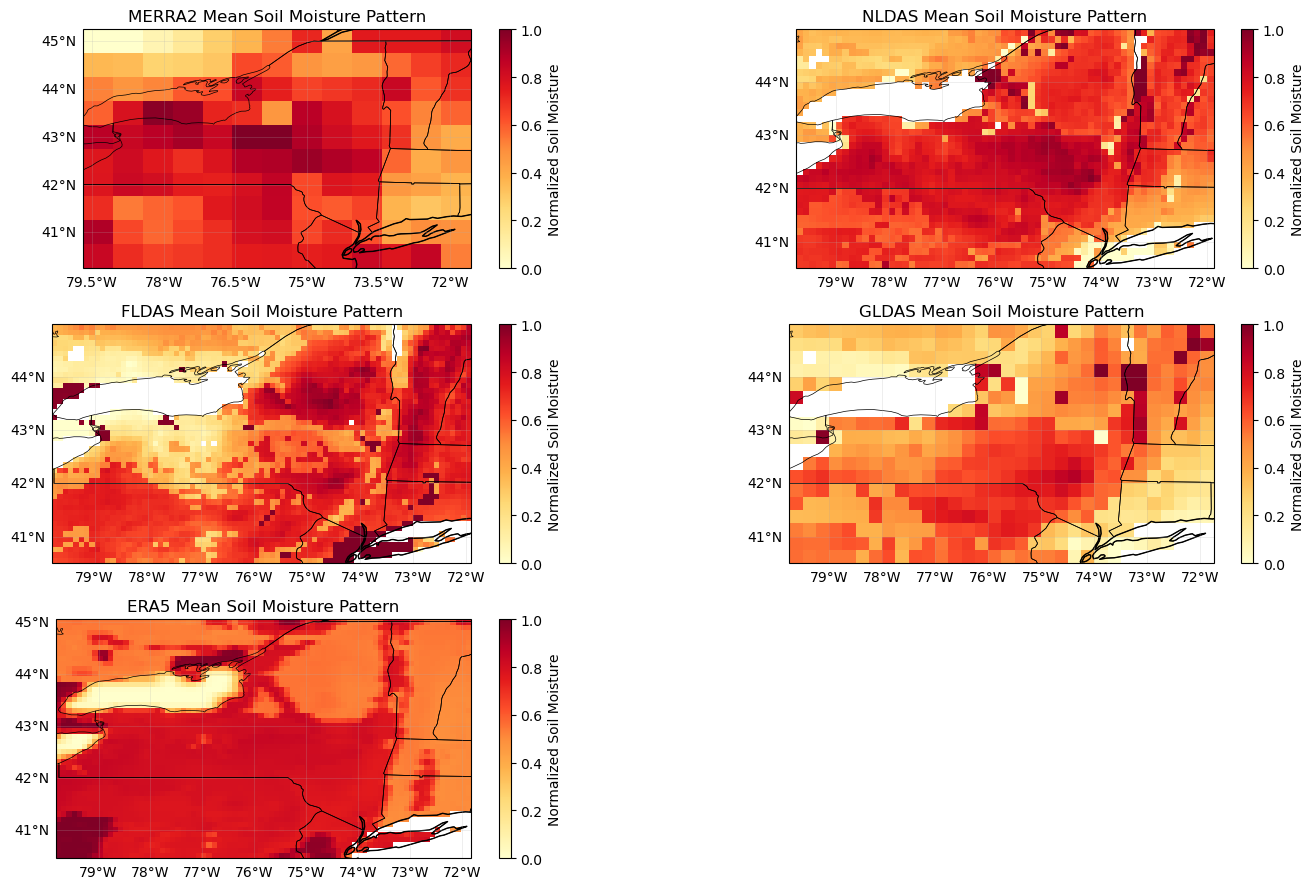

ValueError: Dimensions {'longitude', 'latitude'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'lon': 13, 'lat': 10})

In [62]:
#plot mean spatial agreement for the whole timeseries over the area 

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec

def get_coords(da):
    """Get latitude and longitude coordinates regardless of their names"""
    lat_names = ['latitude', 'lat', 'Y']
    lon_names = ['longitude', 'lon', 'X']
    
    lat_coord = next((coord for coord in da.coords if coord in lat_names), None)
    lon_coord = next((coord for coord in da.coords if coord in lon_names), None)
    
    if lat_coord is None or lon_coord is None:
        raise ValueError(f"Could not find lat/lon coordinates in {list(da.coords)}")
    
    return da[lon_coord], da[lat_coord]

# Calculate temporal means for each dataset
mean_patterns = {}
for name, ds in processed_datasets.items():
    var_name = var_names[name]
    # Calculate temporal mean
    mean = ds[var_name].mean(dim='time')
    # Normalize the mean pattern
    valid_data = mean.values[~np.isnan(mean.values)]
    vmin, vmax = np.percentile(valid_data, [1, 99])
    normalized_mean = (mean - vmin) / (vmax - vmin)
    mean_patterns[name] = normalized_mean

# Create a figure with subplots for each dataset
n_datasets = len(mean_patterns)
fig = plt.figure(figsize=(15, 3 * ((n_datasets + 1) // 2)))
gs = GridSpec(((n_datasets + 1) // 2), 2, figure=fig)

# Find global min/max for consistent colorbar
all_values = []
for mean_pattern in mean_patterns.values():
    all_values.extend(mean_pattern.values.flatten())
vmin, vmax = np.nanpercentile(all_values, [1, 99])

# Plot each dataset's mean pattern
for idx, (name, mean_pattern) in enumerate(mean_patterns.items()):
    ax = fig.add_subplot(gs[idx // 2, idx % 2], projection=ccrs.PlateCarree())
    
    # Get coordinates and create meshgrid
    try:
        # Try to get coordinates directly
        lons = mean_pattern['X'] if 'X' in mean_pattern.coords else mean_pattern['longitude']
        lats = mean_pattern['Y'] if 'Y' in mean_pattern.coords else mean_pattern['latitude']
    except KeyError:
        # If that fails, try alternative coordinate names
        try:
            lons = mean_pattern['lon'] if 'lon' in mean_pattern.coords else mean_pattern.coords[1]
            lats = mean_pattern['lat'] if 'lat' in mean_pattern.coords else mean_pattern.coords[0]
        except:
            print(f"Warning: Using dimension indices for {name}")
            lons = mean_pattern.dims[1]
            lats = mean_pattern.dims[0]
    
    lons, lats = np.meshgrid(lons, lats)
    
    # Plot the mean pattern
    im = ax.pcolormesh(lons, lats, mean_pattern,
                       transform=ccrs.PlateCarree(),
                       cmap='YlOrRd',
                       vmin=vmin, vmax=vmax)
    
    # Add map features
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    
    # Add title
    ax.set_title(f'{name} Mean Soil Moisture Pattern')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Normalized Soil Moisture', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Calculate and plot the ensemble mean and standard deviation
# First, ensure all patterns are on the same grid (use ERA5 grid as reference)
reference_pattern = mean_patterns['ERA5']
try:
    ref_lons = reference_pattern['X'] if 'X' in reference_pattern.coords else reference_pattern['longitude']
    ref_lats = reference_pattern['Y'] if 'Y' in reference_pattern.coords else reference_pattern['latitude']
except KeyError:
    ref_lons = reference_pattern.coords[1]
    ref_lats = reference_pattern.coords[0]

regridded_patterns = []
for name, pattern in mean_patterns.items():
    if name != 'ERA5':
        # Create new coordinates for interpolation
        pattern = pattern.interp(
            {'Y' if 'Y' in pattern.dims else 'latitude': ref_lats,
             'X' if 'X' in pattern.dims else 'longitude': ref_lons}
        )
    regridded_patterns.append(pattern.values)

ensemble_patterns = np.stack(regridded_patterns)
ensemble_mean = np.nanmean(ensemble_patterns, axis=0)
ensemble_std = np.nanstd(ensemble_patterns, axis=0)

# Create a figure for ensemble statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5),
                              subplot_kw={'projection': ccrs.PlateCarree()})

# Create meshgrid for plotting
lons, lats = np.meshgrid(ref_lons, ref_lats)

# Plot ensemble mean
im1 = ax1.pcolormesh(lons, lats, ensemble_mean,
                     transform=ccrs.PlateCarree(),
                     cmap='YlOrRd',
                     vmin=vmin, vmax=vmax)
ax1.coastlines(resolution='50m')
ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)
gl.top_labels = False
gl.right_labels = False
ax1.set_title('Ensemble Mean Soil Moisture Pattern')
plt.colorbar(im1, ax=ax1, label='Normalized Soil Moisture')

# Plot ensemble standard deviation
im2 = ax2.pcolormesh(lons, lats, ensemble_std,
                     transform=ccrs.PlateCarree(),
                     cmap='YlOrRd')
ax2.coastlines(resolution='50m')
ax2.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
gl = ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)
gl.top_labels = False
gl.right_labels = False
ax2.set_title('Ensemble Standard Deviation')
plt.colorbar(im2, ax=ax2, label='Standard Deviation')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSpatial Pattern Agreement Summary:")
print("="*50)
for name1 in mean_patterns.keys():
    for name2 in mean_patterns.keys():
        if name1 < name2:  # Only print each pair once
            pattern1 = mean_patterns[name1].values.flatten()
            pattern2 = mean_patterns[name2].values.flatten()
            
            # Calculate correlation for non-NaN values
            mask = ~np.isnan(pattern1) & ~np.isnan(pattern2)
            correlation = np.corrcoef(pattern1[mask], pattern2[mask])[0,1]
            
            print(f"{name1} vs {name2} Correlation: {correlation:.3f}")

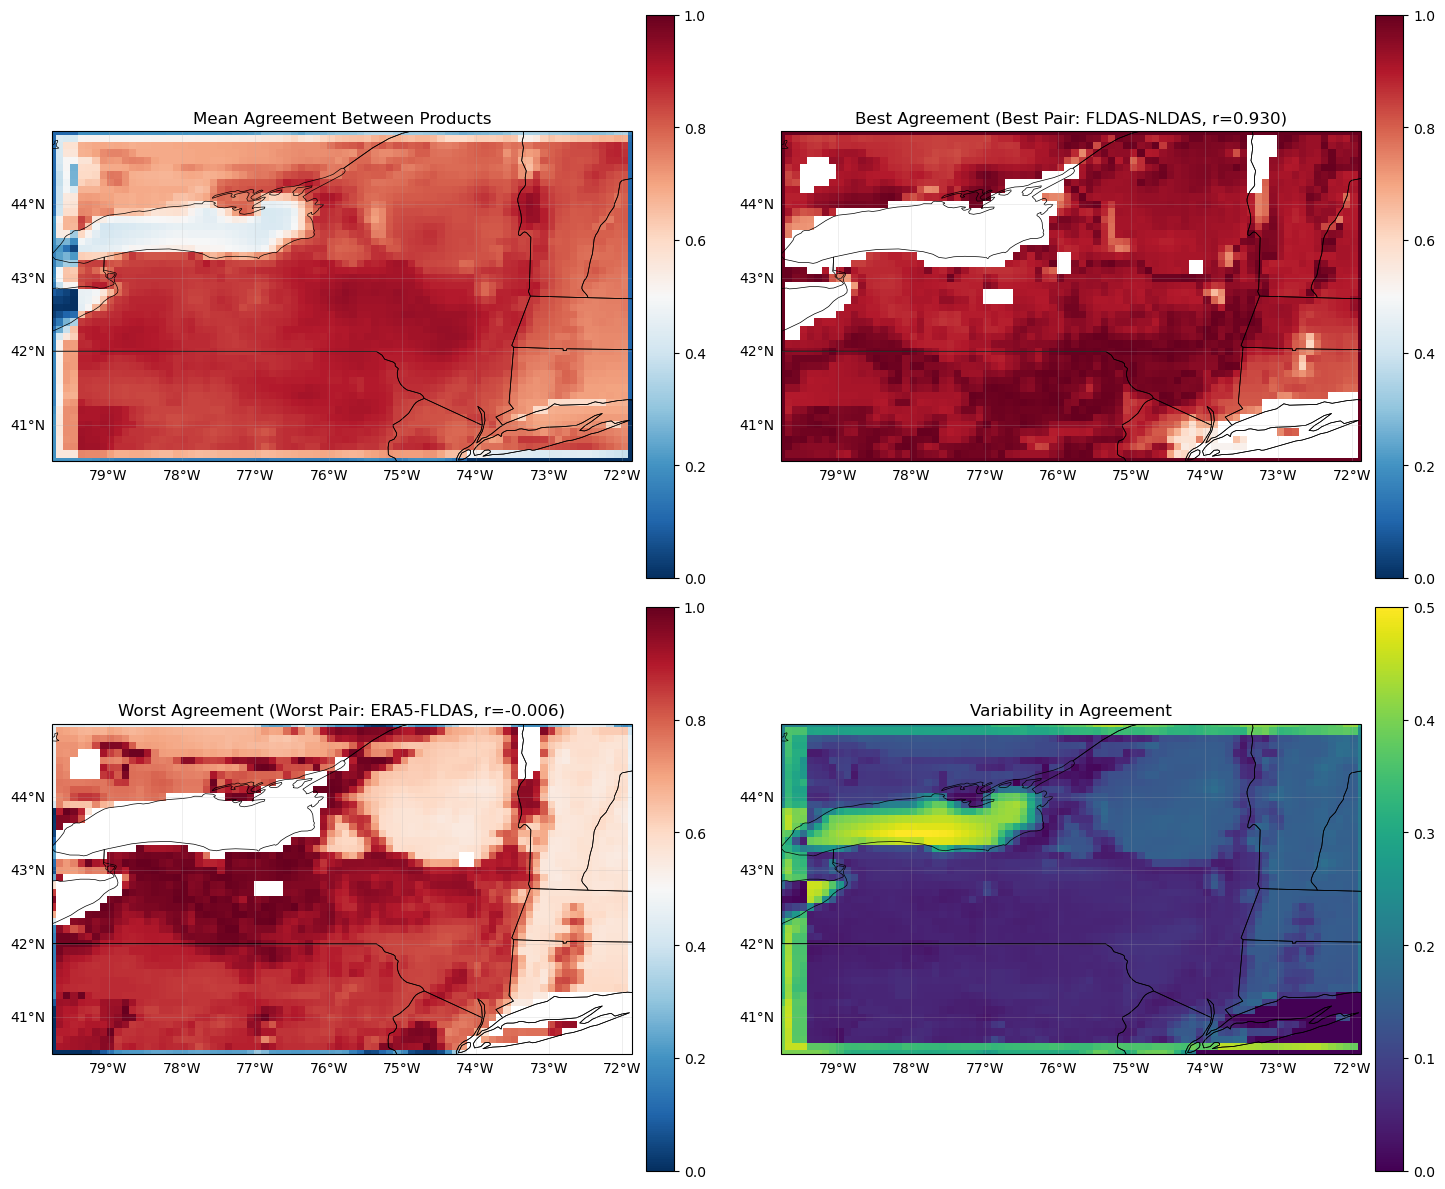


Pairwise Correlations:
MERRA2-NLDAS: 0.705
FLDAS-MERRA2: 0.637
FLDAS-NLDAS: 0.930
FLDAS-GLDAS: 0.746
GLDAS-MERRA2: 0.641
GLDAS-NLDAS: 0.774
ERA5-MERRA2: 0.057
ERA5-NLDAS: 0.141
ERA5-FLDAS: -0.006
ERA5-GLDAS: 0.073

Spatial Statistics:
Mean Agreement: 0.743
Agreement Variability: 0.131
Best Agreement (mean): 0.925
Worst Agreement (mean): 0.768


In [64]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point
from shapely.prepared import prep

def calculate_spatial_correlation(data1, data2):
    """Calculate spatial correlation between two datasets"""
    mask = ~np.isnan(data1) & ~np.isnan(data2)
    if np.any(mask):
        return np.corrcoef(data1[mask], data2[mask])[0,1]
    return np.nan

# Load regridded datasets
regridded_datasets = {}
dataset_names = ['MERRA2', 'NLDAS', 'FLDAS', 'GLDAS', 'ERA5']

for name in dataset_names:
    if name == 'ERA5':
        filename = f"{name.lower()}_processed.nc"
    else:
        filename = f"{name.lower()}_regridded.nc"
    try:
        ds = xr.open_dataset(filename)
        regridded_datasets[name] = ds
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")

# Calculate temporal means
mean_patterns = {}
for name, ds in regridded_datasets.items():
    var_name = list(ds.data_vars)[0]
    mean = ds[var_name].mean(dim='time')
    
    # Normalize
    valid_data = mean.values[~np.isnan(mean.values)]
    vmin, vmax = np.percentile(valid_data, [1, 99])
    normalized_mean = (mean - vmin) / (vmax - vmin)
    mean_patterns[name] = normalized_mean

# Calculate pairwise correlations
correlations = {}
for name1 in mean_patterns:
    for name2 in mean_patterns:
        if name1 < name2:
            corr = calculate_spatial_correlation(
                mean_patterns[name1].values,
                mean_patterns[name2].values
            )
            correlations[f"{name1}-{name2}"] = corr

# Find best and worst pairs
best_pair = max(correlations.items(), key=lambda x: x[1])
worst_pair = min(correlations.items(), key=lambda x: x[1])

def create_water_mask(lons, lats):
    """Create a precise mask for water bodies using natural earth features"""
    # Get the lakes feature
    lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m'
    )
    
    # Create a mask array
    mask = np.ones(lons.shape, dtype=bool)
    
    # Prepare the geometries for faster checking
    prepared_geoms = prep(next(lakes.geometries()))
    
    # Check each point
    for i in range(lons.shape[0]):
        for j in range(lons.shape[1]):
            point = Point(lons[i,j], lats[i,j])
            if prepared_geoms.contains(point):
                mask[i,j] = False
    
    return mask

# Get coordinates
era5_ds = regridded_datasets['ERA5']
if 'X' in era5_ds.coords:
    lons, lats = np.meshgrid(era5_ds.X, era5_ds.Y)
elif 'longitude' in era5_ds.coords:
    lons, lats = np.meshgrid(era5_ds.longitude, era5_ds.latitude)
else:
    lons, lats = np.meshgrid(era5_ds.lon, era5_ds.lat)

# Create the water mask
water_mask = create_water_mask(lons, lats)

# Common plotting parameters
plot_params = {
    'transform': ccrs.PlateCarree(),
    'rasterized': True
}

map_params = {
    'coastlines_kwargs': {'resolution': '50m', 'color': 'black', 'linewidth': 0.5},
    'states_kwargs': {'linewidth': 0.5, 'edgecolor': 'black', 'facecolor': 'none'},
    'extent': [lons.min(), lons.max(), lats.min(), lats.max()]
}

# Create figure with four panels
fig = plt.figure(figsize=(15, 12))

# 1. Mean Agreement
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
mean_agreement = np.nanmean([pattern.values for pattern in mean_patterns.values()], axis=0)
mean_agreement[~water_mask] = np.nan  # Mask water bodies
im1 = ax1.pcolormesh(lons, lats, mean_agreement,
                     cmap='RdBu_r',
                     vmin=0, vmax=1,
                     **plot_params)
ax1.coastlines(**map_params['coastlines_kwargs'])
ax1.add_feature(cfeature.STATES.with_scale('50m'), **map_params['states_kwargs'])
ax1.set_extent(map_params['extent'], crs=ccrs.PlateCarree())
ax1.set_title('Mean Agreement Between Products')
plt.colorbar(im1, ax=ax1, orientation='vertical', pad=0.02)

# 2. Best Agreement
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
best_name1, best_name2 = best_pair[0].split('-')
best_agreement = 1 - np.abs(mean_patterns[best_name1].values - mean_patterns[best_name2].values)
best_agreement[~water_mask] = np.nan  # Mask water bodies
im2 = ax2.pcolormesh(lons, lats, best_agreement,
                     cmap='RdBu_r',
                     vmin=0, vmax=1,
                     **plot_params)
ax2.coastlines(**map_params['coastlines_kwargs'])
ax2.add_feature(cfeature.STATES.with_scale('50m'), **map_params['states_kwargs'])
ax2.set_extent(map_params['extent'], crs=ccrs.PlateCarree())
ax2.set_title(f'Best Agreement (Best Pair: {best_name1}-{best_name2}, r={best_pair[1]:.3f})')
plt.colorbar(im2, ax=ax2, orientation='vertical', pad=0.02)

# 3. Worst Agreement
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
worst_name1, worst_name2 = worst_pair[0].split('-')
worst_agreement = 1 - np.abs(mean_patterns[worst_name1].values - mean_patterns[worst_name2].values)
worst_agreement[~water_mask] = np.nan  # Mask water bodies
im3 = ax3.pcolormesh(lons, lats, worst_agreement,
                     cmap='RdBu_r',
                     vmin=0, vmax=1,
                     **plot_params)
ax3.coastlines(**map_params['coastlines_kwargs'])
ax3.add_feature(cfeature.STATES.with_scale('50m'), **map_params['states_kwargs'])
ax3.set_extent(map_params['extent'], crs=ccrs.PlateCarree())
ax3.set_title(f'Worst Agreement (Worst Pair: {worst_name1}-{worst_name2}, r={worst_pair[1]:.3f})')
plt.colorbar(im3, ax=ax3, orientation='vertical', pad=0.02)

# 4. Variability in Agreement
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
agreement_std = np.nanstd([pattern.values for pattern in mean_patterns.values()], axis=0)
agreement_std[~water_mask] = np.nan  # Mask water bodies
im4 = ax4.pcolormesh(lons, lats, agreement_std,
                     cmap='viridis',
                     vmin=0, vmax=0.5,
                     **plot_params)
ax4.coastlines(**map_params['coastlines_kwargs'])
ax4.add_feature(cfeature.STATES.with_scale('50m'), **map_params['states_kwargs'])
ax4.set_extent(map_params['extent'], crs=ccrs.PlateCarree())
ax4.set_title('Variability in Agreement')
plt.colorbar(im4, ax=ax4, orientation='vertical', pad=0.02)

# Add gridlines to all subplots
for ax in [ax1, ax2, ax3, ax4]:
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPairwise Correlations:")
print("="*50)
for pair, corr in correlations.items():
    print(f"{pair}: {corr:.3f}")

print("\nSpatial Statistics:")
print("="*50)
print(f"Mean Agreement: {np.nanmean(mean_agreement):.3f}")
print(f"Agreement Variability: {np.nanmean(agreement_std):.3f}")
print(f"Best Agreement (mean): {np.nanmean(best_agreement):.3f}")
print(f"Worst Agreement (mean): {np.nanmean(worst_agreement):.3f}")

In [ ]:
#decompose into seasons and plot all 4 spatial agreement again 

def harmonize_units(data: xr.DataArray, name: str) -> xr.DataArray:
    """Convert soil moisture to volumetric units (m³/m³)"""
    if name in ['NLDAS', 'GLDAS']:
        depth = 0.1  # 10cm depth
        return data / (1000 * depth)  # Convert kg/m² to m³/m³
    return data

def get_season(month):
    """Convert month number to season name"""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def decompose_by_season(data):
    """Split data into seasonal components"""
    if isinstance(data, xr.Dataset):
        if 'SFMC' in data:
            data = data['SFMC']
        elif 'SoilM_0_10cm' in data:
            data = data['SoilM_0_10cm']
        elif 'SoilMoi00_10cm_tavg' in data:
            data = data['SoilMoi00_10cm_tavg']
        elif 'SoilMoi0_10cm_inst' in data:
            data = data['SoilMoi0_10cm_inst']
        elif 'swvl1' in data:
            data = data['swvl1']
    
    months = pd.DatetimeIndex(data.time.values).month
    seasons = [get_season(m) for m in months]
    
    seasonal_data = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        season_mask = [s == season for s in seasons]
        seasonal_data[season] = data.isel(time=season_mask)
    
    return seasonal_data

def calculate_seasonal_metrics(datasets_dict):
    """Calculate seasonal metrics with harmonized units"""
    # First harmonize units
    harmonized_datasets = {}
    for name, data in datasets_dict.items():
        if isinstance(data, xr.Dataset):
            if name == 'MERRA2' and 'SFMC' in data:
                harmonized_datasets[name] = harmonize_units(data['SFMC'], name)
            elif name == 'NLDAS' and 'SoilM_0_10cm' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilM_0_10cm'], name)
            elif name == 'FLDAS' and 'SoilMoi00_10cm_tavg' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilMoi00_10cm_tavg'], name)
            elif name == 'GLDAS' and 'SoilMoi0_10cm_inst' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilMoi0_10cm_inst'], name)
            elif name == 'ERA5' and 'swvl1' in data:
                harmonized_datasets[name] = harmonize_units(data['swvl1'], name)
    
    # Split into seasons
    seasonal_datasets = {}
    for name, data in harmonized_datasets.items():
        seasonal_datasets[name] = decompose_by_season(data)
        print(f"\nDecomposed {name} into seasons")
    
    seasonal_metrics = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        print(f"\nProcessing {season}")
        
        season_data = {}
        for name in harmonized_datasets.keys():
            season_data[name] = seasonal_datasets[name][season]
        
        # Calculate grid dimensions
        min_lat = min(data.shape[1] for data in season_data.values())
        min_lon = min(data.shape[2] for data in season_data.values())
        
        # Initialize arrays
        mean_correlation = np.zeros((min_lat, min_lon))
        max_correlation = np.zeros((min_lat, min_lon))
        min_correlation = np.zeros((min_lat, min_lon))
        correlation_std = np.zeros((min_lat, min_lon))
        best_pairs = np.empty((min_lat, min_lon), dtype='U20')
        worst_pairs = np.empty((min_lat, min_lon), dtype='U20')
        
        # Calculate correlations
        for i in range(min_lat):
            for j in range(min_lon):
                correlations = []
                pairs = []
                
                for name1, data1 in season_data.items():
                    for name2, data2 in season_data.items():
                        if name1 < name2:
                            try:
                                ts1 = data1[:, i, j]
                                ts2 = data2[:, i, j]
                                
                                d1 = ts1.values if hasattr(ts1, 'values') else ts1
                                d2 = ts2.values if hasattr(ts2, 'values') else ts2
                                
                                valid_mask = ~(np.isnan(d1) | np.isnan(d2))
                                if valid_mask.any():
                                    d1_valid = d1[valid_mask]
                                    d2_valid = d2[valid_mask]
                                    
                                    if len(d1_valid) >= 2:
                                        corr = np.corrcoef(d1_valid, d2_valid)[0,1]
                                        if not np.isnan(corr):
                                            correlations.append(corr)
                                            pairs.append(f"{name1}-{name2}")
                            
                            except Exception as e:
                                continue
                
                if correlations:
                    mean_correlation[i,j] = np.mean(correlations)
                    max_idx = np.argmax(correlations)
                    min_idx = np.argmin(correlations)
                    max_correlation[i,j] = correlations[max_idx]
                    min_correlation[i,j] = correlations[min_idx]
                    correlation_std[i,j] = np.std(correlations)
                    best_pairs[i,j] = pairs[max_idx]
                    worst_pairs[i,j] = pairs[min_idx]
                else:
                    mean_correlation[i,j] = np.nan
                    max_correlation[i,j] = np.nan
                    min_correlation[i,j] = np.nan
                    correlation_std[i,j] = np.nan
        
        # Get coordinates
        ref_data = season_data['MERRA2']
        try:
            lats = ref_data.lat.values[:min_lat]
            lons = ref_data.lon.values[:min_lon]
        except AttributeError:
            try:
                lats = ref_data.latitude.values[:min_lat]
                lons = ref_data.longitude.values[:min_lon]
            except AttributeError:
                lats = np.arange(min_lat)
                lons = np.arange(min_lon)
        
        seasonal_metrics[season] = {
            'mean_correlation': xr.DataArray(
                mean_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'max_correlation': xr.DataArray(
                max_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'min_correlation': xr.DataArray(
                min_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'correlation_std': xr.DataArray(
                correlation_std,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'best_pairs': best_pairs,
            'worst_pairs': worst_pairs
        }
    
    return seasonal_metrics

def plot_season_detailed(metrics, season):
    """Create detailed seasonal plots with proper units and enhanced visibility"""
    fig = plt.figure(figsize=(20, 15))
    proj = ccrs.PlateCarree()
    
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
              '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    colors.reverse()
    cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors)
    
    plots = [
        ('mean_correlation', 'Mean Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('min_correlation', 'Worst Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('max_correlation', 'Best Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('correlation_std', 'Agreement Variability', 'viridis', 'Std. Dev.', False)
    ]
    
    for idx, (metric, title, colormap, label, use_correlation_range) in enumerate(plots, 1):
        ax = fig.add_subplot(2, 2, idx, projection=proj)
        
        # Add gridlines with enhanced visibility
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
        if metric == 'max_correlation':
            unique_pairs, counts = np.unique(metrics['best_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common best pair: {most_common}'
        elif metric == 'min_correlation':
            unique_pairs, counts = np.unique(metrics['worst_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common worst pair: {most_common}'
        
        if use_correlation_range:
            data = metrics[metric].values
            valid_data = data[~np.isnan(data)]
            vmin = min(-1, np.min(valid_data)) if len(valid_data) > 0 else -1
            vmax = max(1, np.max(valid_data)) if len(valid_data) > 0 else 1
            extend = 'both'
            center = 0
        else:
            vmin = None
            vmax = None
            extend = 'neither'
            center = None
        
        # Direct pcolormesh plotting instead of xarray's plot method
        lons, lats = np.meshgrid(metrics[metric].longitude, metrics[metric].latitude)
        im = ax.pcolormesh(
            lons, lats,
            metrics[metric].values,
            transform=proj,
            cmap=colormap,
            vmin=vmin,
            vmax=vmax
        )
        
        # Add colorbar
        cb = plt.colorbar(im, ax=ax, label=label, extend=extend, shrink=0.8)
        cb.set_label(label, size=10)
        cb.ax.tick_params(labelsize=8)
        
        # Enhanced map features
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=100,facecolor='white')
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=100, facecolor='white')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=0.5)
        
        # Set extent with minimal padding
        lon_min, lon_max = metrics[metric].longitude.min(), metrics[metric].longitude.max()
        lat_min, lat_max = metrics[metric].latitude.min(), metrics[metric].latitude.max()
        padding = 0.05  # Reduced padding
        ax.set_extent([
            lon_min - padding,
            lon_max + padding,
            lat_min - padding,
            lat_max + padding
        ], crs=proj)
        
        ax.set_title(title, pad=10, fontsize=12)
    
    plt.suptitle(f'{season} Soil Moisture Product Agreement', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

def analyze_seasonal_patterns(datasets):
    """Run complete seasonal analysis"""
    # Calculate seasonal metrics
    seasonal_metrics = calculate_seasonal_metrics(datasets)
    
    # Create separate plots for each season
    season_figs = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        # Create and display plot
        fig = plot_season_detailed(seasonal_metrics[season], season)
        season_figs[season] = fig
        plt.show()
        
        # Print summary statistics for this season
        print(f"\n=== {season} Statistics ===")
        for metric in ['mean_correlation', 'max_correlation', 'min_correlation', 'correlation_std']:
            data = seasonal_metrics[season][metric].values
            valid_data = data[~np.isnan(data)]
            if len(valid_data) > 0:
                print(f"\n{metric}:")
                print(f"Mean: {np.mean(valid_data):.3f}")
                print(f"Median: {np.median(valid_data):.3f}")
                print(f"Min: {np.min(valid_data):.3f}")
                print(f"Max: {np.max(valid_data):.3f}")
    
    return seasonal_metrics, season_figs
# Run analysis
datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

metrics, figures = analyze_seasonal_patterns(datasets)

In [ ]:
#PCA to identify modes of variation 

def perform_pca_analysis(datasets: Dict[str, xr.Dataset], n_components: int = 3) -> Dict:
    """
    Perform PCA analysis on multiple soil moisture datasets.
    """
    # Dataset configurations - simplified without depth information
    config = {
        'MERRA2': {'var': 'SFMC'},
        'NLDAS': {'var': 'SoilM_0_10cm'},
        'FLDAS': {'var': 'SoilMoi00_10cm_tavg'},
        'GLDAS': {'var': 'SoilMoi0_10cm_inst'},
        'ERA5': {'var': 'swvl1'}
    }
    
    # First, find overlapping time period
    print("Finding overlapping time period...")
    time_ranges = {}
    for name, ds in datasets.items():
        if isinstance(ds, xr.Dataset):
            var_name = config[name]['var']
            time = ds[var_name].time
        else:
            time = ds.time
        time_ranges[name] = (time.min().values, time.max().values)
        print(f"{name}: {pd.to_datetime(time_ranges[name][0])} to {pd.to_datetime(time_ranges[name][1])}")
    
    # Find common time period
    start_time = max(t[0] for t in time_ranges.values())
    end_time = min(t[1] for t in time_ranges.values())
    
    print(f"\nCommon time period: {pd.to_datetime(start_time)} to {pd.to_datetime(end_time)}")
    
    # Preprocess and align datasets
    processed_data = {}
    reference_grid = None
    
    print("\nPreprocessing datasets...")
    
    for name, ds in datasets.items():
        try:
            # Extract variable
            if isinstance(ds, xr.Dataset):
                data = ds[config[name]['var']]
            else:
                data = ds
                
            # Handle coordinates
            if name == 'ERA5':
                data = data.rename({'latitude': 'lat', 'longitude': 'lon'})
            elif name == 'FLDAS':
                data = data.rename({'X': 'lon', 'Y': 'lat'})
                
            # Select common time period
            data = data.sel(time=slice(start_time, end_time))
            
            # Store for later use
            processed_data[name] = data
            
            # Set reference grid from first dataset
            if reference_grid is None:
                reference_grid = data
                
            print(f"Processed {name} shape: {data.shape}")
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue
    
    print("\nAligning datasets spatially...")
    
    # Align all datasets to reference grid
    aligned_data = {}
    for name, data in processed_data.items():
        # Spatial interpolation
        if name != list(processed_data.keys())[0]:
            data = data.interp(
                lat=reference_grid.lat,
                lon=reference_grid.lon,
                method='linear'
            )
        
        aligned_data[name] = data
        print(f"Aligned {name} shape: {data.shape}")
    
    print("\nPreparing data matrix for PCA...")
    
    # Calculate spatial grid size
    n_times = len(reference_grid.time)
    n_lats = len(reference_grid.lat)
    n_lons = len(reference_grid.lon)
    n_spatial_points = n_lats * n_lons
    
    # Prepare data matrix for PCA
    X = np.zeros((n_times, n_spatial_points * len(aligned_data)))
    valid_mask = np.ones((n_times, n_spatial_points * len(aligned_data)), dtype=bool)
    
    for i, (name, data) in enumerate(aligned_data.items()):
        start_idx = i * n_spatial_points
        end_idx = (i + 1) * n_spatial_points
        
        # Reshape data to 2D (time, space)
        reshaped = data.values.reshape(n_times, -1)
        X[:, start_idx:end_idx] = reshaped
        
        # Update valid mask
        valid_mask[:, start_idx:end_idx] = ~np.isnan(reshaped)
    
    # Remove columns with any NaN values
    valid_columns = np.all(~np.isnan(X), axis=0)
    X = X[:, valid_columns]
    
    print(f"Final data matrix shape: {X.shape}")
    
    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_scaled)
    
    # Reconstruct spatial patterns
    spatial_patterns = []
    for i in range(n_components):
        # Initialize empty pattern
        pattern = np.full((n_lats, n_lons), np.nan)
        
        # Get valid indices for the first dataset only
        dataset_valid_cols = valid_columns[:n_spatial_points]
        valid_indices = np.where(dataset_valid_cols)[0]
        
        # Reshape valid indices back to 2D grid
        grid_indices = np.unravel_index(valid_indices, (n_lats, n_lons))
        
        # Fill in the pattern with PCA components
        pattern[grid_indices] = pca.components_[i, :len(valid_indices)]
        
        spatial_patterns.append(pattern)
    
    # Create xarray DataArrays for spatial patterns
    spatial_patterns_xr = []
    for i in range(n_components):
        pattern_xr = xr.DataArray(
            spatial_patterns[i],
            coords={
                'lat': reference_grid.lat,
                'lon': reference_grid.lon
            },
            dims=['lat', 'lon']
        )
        spatial_patterns_xr.append(pattern_xr)
    
    # Calculate temporal correlations with original datasets
    correlations = {}
    for name, data in aligned_data.items():
        data_flat = data.values.reshape(n_times, -1)
        valid_points = np.all(~np.isnan(data_flat), axis=0)
        data_flat = data_flat[:, valid_points]
        
        if data_flat.size > 0:
            data_scaled = scaler.fit_transform(data_flat)
            
            corr = np.zeros(n_components)
            for i in range(n_components):
                corr[i] = np.corrcoef(components[:, i], data_scaled.mean(axis=1))[0, 1]
            correlations[name] = corr
        else:
            print(f"Warning: No valid data points for {name}")
            correlations[name] = np.full(n_components, np.nan)
    
    return {
        'components': components,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'spatial_patterns': spatial_patterns_xr,
        'correlations': correlations,
        'time_coords': reference_grid.time
    }

def plot_pca_results(pca_results: Dict, figsize: Tuple[int, int] = (12, 25)) -> None:
    """
    Create comprehensive visualization of PCA results with proper map scaling and label spacing.
    """
    n_components = len(pca_results['spatial_patterns'])
    
    # Create figure with GridSpec - increased height to accommodate labels
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(n_components + 2, 1, figure=fig, height_ratios=[0.7, 0.7, 2, 2, 2],
                 hspace=0.8)  # Increased spacing between subplots
    
    # Plot explained variance
    ax_var = fig.add_subplot(gs[0])
    explained_var = pca_results['explained_variance_ratio'] * 100
    cum_explained_var = np.cumsum(explained_var)
    
    # Enhanced variance plot
    bars = ax_var.bar(range(1, len(explained_var) + 1), explained_var, 
                      alpha=0.7, color='skyblue', label='Individual')
    ax_var.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, 
                'ro-', label='Cumulative', linewidth=2)
    
    # Add value labels on bars
    for bar, ev, cev in zip(bars, explained_var, cum_explained_var):
        ax_var.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                   f'{ev:.1f}%', ha='center', va='bottom')
        ax_var.text(bar.get_x() + bar.get_width()/2, cev,
                   f'{cev:.1f}%', ha='center', va='bottom', color='red')
    
    ax_var.set_xlabel('Principal Component', fontsize=12)
    ax_var.set_ylabel('Explained Variance (%)', fontsize=12)
    ax_var.set_title('Explained Variance by Principal Components', fontsize=14, pad=20)
    ax_var.grid(True, alpha=0.3)
    ax_var.legend(fontsize=10)
    
    # Plot correlations heatmap
    ax_corr = fig.add_subplot(gs[1])
    corr_data = pd.DataFrame(pca_results['correlations']).T
    corr_data.columns = [f'PC{i+1}' for i in range(corr_data.shape[1])]
    
    # Enhanced correlation heatmap
    sns.heatmap(corr_data, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                annot=True, fmt='.2f', ax=ax_corr, cbar_kws={'label': 'Correlation'})
    ax_corr.set_title('Correlations between PCs and Original Datasets', fontsize=14, pad=20)
    
    # Plot spatial patterns with enhanced cartopy maps
    proj = ccrs.PlateCarree()
    
    for i in range(n_components):
        ax = fig.add_subplot(gs[i+2], projection=proj)
        
        pattern = pca_results['spatial_patterns'][i]
        
        # Get data extents
        lon_min, lon_max = pattern.lon.min(), pattern.lon.max()
        lat_min, lat_max = pattern.lat.min(), pattern.lat.max()
        
        # Create meshgrid for pcolormesh
        lons = pattern.lon.values
        lats = pattern.lat.values
        lons_mesh, lats_mesh = np.meshgrid(lons, lats)
        
        # Create plot with correct boundaries
        plot_data = pattern.values
        im = ax.pcolormesh(
            lons_mesh, lats_mesh,
            plot_data,
            transform=proj,
            cmap='RdBu_r',
            vmin=-np.nanmax(np.abs(plot_data)),
            vmax=np.nanmax(np.abs(plot_data))
        )
        
        # Add Natural Earth features with proper scaling
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=100,facecolor='white')
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=100, facecolor='white')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=0.5)
        
        # Position colorbar below the map with more space
        cb_ax = ax.inset_axes([0.05, -0.2, 0.9, 0.03])
        cb = plt.colorbar(im, cax=cb_ax, orientation='horizontal')
        cb.set_label('Loading', size=10)
        cb.ax.tick_params(labelsize=8)
        
        # Add gridlines with labels - adjusted for better spacing
        gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.5, 
                         color='gray', alpha=0.3, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8, 'rotation': 0}
        gl.ylabel_style = {'size': 8}
        
        # Adjust label padding
        gl.xpadding = 10
        gl.ypadding = 10
        
        # Set map extent with minimal padding
        padding = 0.25
        ax.set_extent([
            lon_min - padding,
            lon_max + padding,
            lat_min - padding,
            lat_max + padding
        ], crs=proj)
        
        # Force aspect ratio to be equal
        ax.set_aspect('equal')
        
        # Enhanced title with explained variance - moved up slightly
        ax.set_title(f'PC{i+1} Spatial Pattern\n'
                    f'Explained Variance: {explained_var[i]:.1f}%\n'
                    f'Cumulative: {cum_explained_var[i]:.1f}%',
                    fontsize=12, pad=30)
    
    # Adjust layout with more space for labels
    plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.05, hspace=0.8)
    
    # Add time series plot as a new figure
    plt.figure(figsize=(15, 5))
    times = pd.to_datetime(pca_results['time_coords'].values)
    components = pca_results['components']
    
    for i in range(n_components):
        plt.plot(times, components[:, i], 
                label=f'PC{i+1} ({explained_var[i]:.1f}%)',
                linewidth=2)
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Component Value', fontsize=12)
    plt.title('Time Series of Principal Components', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print summary statistics
    print("\nPCA Summary Statistics:")
    print("-" * 50)
    print(f"Total explained variance: {np.sum(explained_var):.1f}%")
    print(f"Number of components: {n_components}")
    print("\nComponent correlations with original datasets:")
    print(corr_data.round(3))
    
    plt.show()

# Example usage:
pca_results = perform_pca_analysis(datasets)
plot_pca_results(pca_results)